In [1]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi

Wed Nov 16 12:56:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
DATA_ROOT = '/content/drive/MyDrive/Magistr/VMM/data'
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import torch.nn as nn
import librosa
import librosa.display
import torch
import numpy as np
from pydub import AudioSegment
from torch.utils.data import Dataset, DataLoader
from typing import List
import glob
from sklearn.manifold import TSNE
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import os

# Songs visualization and preprocessing

In [5]:
class SegmentedSong:
    def __init__(self, path: str, fmt: str = 'wav', window: int = 400, shift: int = 1):
        self.path = path
        self.window = window
        self.shift = shift
        self.song = None
        self.spec_data = None
        try:
            self.song = AudioSegment.from_file(path, format=fmt)
            self.spec_data = self.__get_spec_data(*self.__convert_to_librosa(self.song))
        except:
            pass
        
    def __len__(self):
        if self.spec_data is None:
          return 0
        else:
          return int(self.spec_data.shape[1] - self.window) // self.shift
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if not self.song:
            raise StopIteration
            
        if self.n < int(self.spec_data.shape[1] - self.window) // self.shift:
            self.n += 1
            spec_segment = self.at(self.n)
            return spec_segment
        else:
            raise StopIteration

    def at(self, index):
      return self.spec_data[:, index*self.shift:(index*self.shift + self.window)]
    
    @staticmethod
    def __convert_to_librosa(segment):
        samples = segment.get_array_of_samples()
        y = np.array(samples).astype(np.float32)/32768 # 16 bit
        return y, segment.frame_rate
    
    @staticmethod
    def __get_spec_data(y, samplerate):
        # this is the number of samples in a window per fft
        n_fft = 2048
        # The amount of samples we are shifting after each fft
        hop_length = 512

        mel_signal = librosa.feature.melspectrogram(y=y, sr=samplerate, hop_length=hop_length, n_fft=n_fft)
        spectrogram = np.abs(mel_signal)
        power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
        return power_to_db

In [6]:
song = SegmentedSong(f"{DATA_ROOT}/reggae/reggae.00000.wav", fmt='wav')

In [7]:
len(song)

893

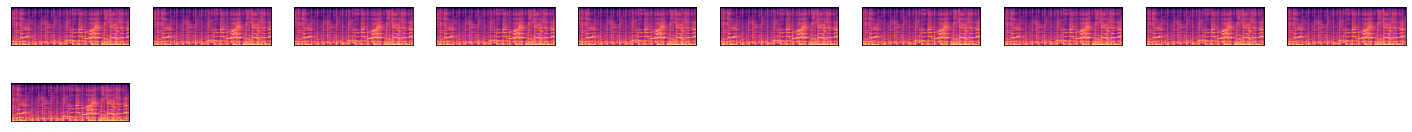

In [8]:
window = 10

fig = plt.figure(figsize=(25, 4))
fig.tight_layout()
for i, spec_data in enumerate(song):
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(spec_data, origin="lower", cmap=plt.get_cmap("magma"))
    if i == 10:
        break

# Creating AutoEncoder

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(start_dim=1),
            nn.Linear(400*16*2, 500),
            nn.ReLU(True),
            nn.Linear(500, 300)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(300, 500),
            nn.ReLU(True),
            nn.Linear(500, 400*16*2),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(4, 32, 100)),
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        compressed = x
        x = self.decoder(x)
        return x, compressed

autoencoder = ConvAutoencoder()
print(autoencoder)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=12800, out_features=500, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=500, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=12800, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(4, 32, 100))
    (5): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16

In [10]:
image = next(iter(song))

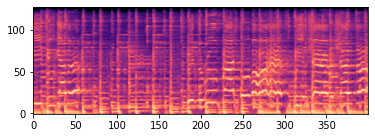

In [11]:
plt.imshow(image, origin="lower", cmap=plt.get_cmap("magma"))
plt.show()

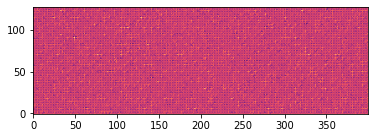

In [12]:
img, compressed = autoencoder(torch.Tensor(np.array([image])).view(1, 1, 128, 400))
plt.imshow(img.view(128, 400).detach().numpy(), origin="lower", cmap=plt.get_cmap("magma"))
plt.show()

# Creating dataset and loader

In [13]:
class SongSegmentsDataset(Dataset):
    def __init__(self, root_dir, from_slice=0, to_slice=20):
        self.root_dir = root_dir
        self.from_slice=from_slice
        self.to_slice=to_slice
        self.songs = self.__get_songs()

    def __len__(self):
        return sum(map(lambda x: len(x), self.songs))

    def __getitem__(self, idx):
        for song in self.songs:
          if idx - len(song) >= 0:
            idx -= len(song)
          else:
            sample = song.at(idx)
            return sample
    
    def __get_songs(self):
        genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
        songs_list = []
        for genre in genres:
            songs_list += [path for path in glob.glob(f'{self.root_dir}/{genre}/*')][self.from_slice:self.to_slice]
        return [SegmentedSong(song_path, fmt='wav') for song_path in songs_list]

In [14]:
train_dataset = SongSegmentsDataset(DATA_ROOT, from_slice=0, to_slice=2)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

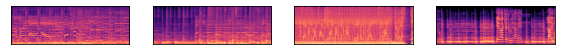

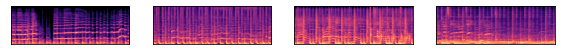

In [16]:
for i_batch, sample_batched in enumerate(train_loader):
    fig = plt.figure(figsize=(25, 4))
    fig.tight_layout()
    for i, sample in enumerate(sample_batched):
        ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
        ax.imshow(sample, origin="lower", cmap=plt.get_cmap("magma"))
    if i_batch == 1:
        break

# Training the model

In [17]:
class TrainTester:
    def __init__(self, device, model):
        self.device = device
        self.model = model.to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_test(self, train_loader, test_loader, num_epochs=20):
        train_loss_output = []
        test_loss_output = []

        for epoch in range(1, num_epochs + 1):
            print(f'Epoch {epoch}')
            tr_loss = self.train(train_loader)
            print('\tTraining Loss: {:.6f}'.format(tr_loss))
            ts_loss = self.test(test_loader)
            print('\tTest Loss: {:.6f}'.format(ts_loss))

            train_loss_output.append(tr_loss)
            test_loss_output.append(ts_loss)
        return train_loss_output, test_loss_output
        
    def train(self, train_loader):
        self.model.train()
        train_loss = 0

        self.model.zero_grad()
        for images in train_loader:    
            images = images.to(self.device)
            images = images.view(-1, 1, 128, 400)

            outputs, _ = self.model(images)

            loss = self.criterion(outputs, images)

            train_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            self.model.zero_grad()

        train_loss /= len(train_loader)
        return train_loss
    
    def test(self, test_loader):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for images in test_loader:

                images = images.to(self.device)
                images = images.view(-1, 1, 128, 400)
                
                outputs, _ = self.model(images)

                test_loss += self.criterion(outputs, images).item()
        test_loss /= len(test_loader)
        return test_loss

In [ ]:
train_dataset = SongSegmentsDataset(DATA_ROOT, from_slice=0, to_slice=70)
test_dataset = SongSegmentsDataset(DATA_ROOT, from_slice=71, to_slice=99)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=0)

In [ ]:
print(f'Train data points: {len(train_dataset)}')
print(f'Test data points: {len(test_dataset)}')

Train data points: 624834
Test data points: 250040


In [ ]:
# first 2 10-epochs not shown here
# 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tt = TrainTester(device, autoencoder)
train_losses, test_losses = tt.train_test(train_loader, test_loader, 10)

Epoch 1
	Training Loss: 61.825328
	Test Loss: 62.111362
Epoch 2
	Training Loss: 61.741550
	Test Loss: 62.011770
Epoch 3
	Training Loss: 61.710087
	Test Loss: 62.285471
Epoch 4
	Training Loss: 61.689224
	Test Loss: 62.022094
Epoch 5
	Training Loss: 61.666789
	Test Loss: 62.153332
Epoch 6
	Training Loss: 61.643370
	Test Loss: 61.984762
Epoch 7
	Training Loss: 61.619504
	Test Loss: 62.036643
Epoch 8
	Training Loss: 61.600323
	Test Loss: 62.070897
Epoch 9
	Training Loss: 61.582965
	Test Loss: 62.041799
Epoch 10
	Training Loss: 61.559840
	Test Loss: 62.082276


In [ ]:
# 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tt = TrainTester(device, autoencoder)
train_losses, test_losses = tt.train_test(train_loader, test_loader, 10)

Epoch 1
	Training Loss: 61.588645
	Test Loss: 62.247142
Epoch 2
	Training Loss: 61.521296
	Test Loss: 62.098293
Epoch 3
	Training Loss: 61.507943
	Test Loss: 62.088846
Epoch 4
	Training Loss: 61.492747
	Test Loss: 62.164981
Epoch 5
	Training Loss: 61.479534
	Test Loss: 62.116064
Epoch 6
	Training Loss: 61.463233
	Test Loss: 62.367095
Epoch 7
	Training Loss: 61.449499
	Test Loss: 62.123603
Epoch 8
	Training Loss: 61.436114
	Test Loss: 62.364865
Epoch 9
	Training Loss: 61.423611
	Test Loss: 62.245132
Epoch 10
	Training Loss: 61.410712
	Test Loss: 62.099732


In [ ]:
# 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tt = TrainTester(device, autoencoder)
train_losses, test_losses = tt.train_test(train_loader, test_loader, 10)

Epoch 1
	Training Loss: 61.419660
	Test Loss: 62.297059
Epoch 2
	Training Loss: 61.373748
	Test Loss: 62.051883
Epoch 3
	Training Loss: 61.357291
	Test Loss: 62.134228
Epoch 4
	Training Loss: 61.342980
	Test Loss: 62.075580
Epoch 5
	Training Loss: 61.332353
	Test Loss: 62.018756
Epoch 6
	Training Loss: 61.324564
	Test Loss: 62.139292
Epoch 7
	Training Loss: 61.313868
	Test Loss: 62.005468
Epoch 8
	Training Loss: 61.302548
	Test Loss: 61.976474
Epoch 9
	Training Loss: 61.295032
	Test Loss: 62.059232
Epoch 10
	Training Loss: 61.283936
	Test Loss: 62.014467


In [ ]:
torch.save(autoencoder.state_dict(), f'/content/drive/MyDrive/Magistr/VMM/autoencoder.pth')

In [18]:
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/Magistr/VMM/autoencoder.pth', map_location=torch.device('cpu')))
device = torch.device('cpu')

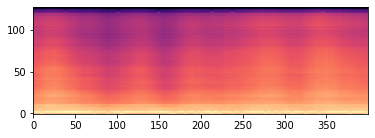

In [ ]:
input = torch.Tensor(np.array([image])).view(1, 1, 128, 400)
img, compressed = autoencoder(input.to(device))
plt.imshow(img.view(128, 400).detach().cpu().numpy(), origin="lower", cmap=plt.get_cmap("magma"))
plt.show()

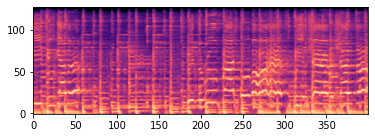

In [ ]:
plt.imshow(image, origin="lower", cmap=plt.get_cmap("magma"))
plt.show()

## Creating weighted vectors for songs with the learnt model

In [19]:
class WeightedSongEmbedding:
  def __init__(self, path, genre, fmt='wav'):
    self.path = path
    self.segments = SegmentedSong(path, fmt=fmt, shift=20)
    self.embedding = None
    self.genre = genre
  
  def calculate_embedding(self, autoencoder):
    if self.embedding is not None:
      return self.embedding
    embeddings = self.__calculate_embeddings(autoencoder)
    return np.mean(embeddings, axis=0)

  def __calculate_embeddings(self, autoencoder):
    embeddings = np.ones(300)
    for segment in iter(self.segments):
      input = torch.Tensor(np.array([segment])).view(1, 1, 128, 400)
      _, embedding = autoencoder(input)
      detached = embedding.detach().numpy()
      embeddings = np.vstack([embeddings, detached])
    return embeddings[1:]

In [20]:
emb = WeightedSongEmbedding(f"{DATA_ROOT}/reggae/reggae.00000.wav", 'reggae').calculate_embedding(autoencoder)

In [21]:
len(emb)

300

In [25]:
class EmbsVisualizer:
    def __init__(self, root_dir, autoencoder, songs_per_genre = 10):
      self.root_dir = root_dir
      self.songs_per_genre = songs_per_genre
      self.autoencoder = autoencoder
      self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
      self.songs = self.__get_songs_per_genre()

    def visualize_embeddings(self):
      embs = self.__get_embeddings()
      reduced = self.__tsne_reduce(embs, perplexity=20)
      plt.figure(figsize=(12, 6))
      scatter = plt.scatter(reduced[1], reduced[2], c=reduced.genre, cmap='jet')
      handles, _ = scatter.legend_elements()
      plt.legend(handles=handles, loc="lower right", title="Genre", labels=self.genres)
      plt.show()

    def __get_embeddings(self):
      arr = [song_emb for songs in self.songs.values() for song_emb in songs.values()]
      embs = pd.DataFrame(map(lambda x: [x.genre] + x.calculate_embedding(self.autoencoder).ravel().tolist(), arr))
      embs.rename(columns={0: 'genre'}, inplace=True)
      embs = self.__remap_genres(embs)
      return embs

    def __remap_genres(self, embs):
      genres_mapping = {self.genres[i]: i for i in range(len(self.genres))}
      embs.genre = embs.apply(lambda x: genres_mapping[x.genre], axis=1)
      return embs

    def __get_songs_per_genre(self):
      songs = {key: {} for key in self.genres}
      for song_path, genre in self.__iterate_songs():
        song_emb = WeightedSongEmbedding(song_path, genre)
        songs[genre][song_path] = song_emb
      return songs

    def __iterate_songs(self):
      for genre in self.genres:
        arr = [self.__path_for_song(genre, idx) for idx in range(self.songs_per_genre)]
        for item in arr:
          yield item, genre

    def __path_for_song(self, genre: str, idx: int):
      return os.path.join(self.root_dir, genre, f"{genre}.{'{:05d}'.format(idx)}.wav")

    @staticmethod
    def __tsne_reduce(df: pd.DataFrame, perplexity: int = 30) -> pd.DataFrame:
      """
      Reduces the dataset into 2 dimensions using t-SNE dimensionality reduction
      :param perplexity: Perplexity of t-SNE dimensionality reduction
      :param df: Dataset of learned representations
      :return: Learned representations reduced to 2 dimensions
      """
      feature_cols = [x for x in df.columns if isinstance(x, int)]
      x = df.loc[:, feature_cols]
      tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, init='random')
      tsne_results = tsne.fit_transform(x)
      cols = [col + 1 for col in range(2)]
      tsne_df = pd.DataFrame(data=tsne_results, columns=cols)
      return pd.concat([tsne_df, df[['genre']]], axis=1)

In [26]:
vis = EmbsVisualizer(DATA_ROOT, autoencoder, 50)

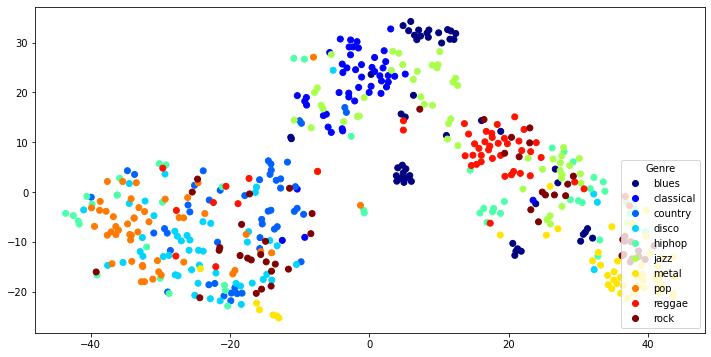

In [27]:
vis.visualize_embeddings()